# Method 7 - Best Ideas High Minus Low Concentration

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Herfindahl

inst_data['target_sq'] = inst_data['target'] ** 2
herf = inst_data.groupby(['datadate', 'institution_id'])['target_sq'].sum().rename('herf').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns from Intra-Cap Portfolio Weight per Shumway, Szefler, Yuan 2009

%store -r cap_exp_ret

valid_data = valid_data.merge(cap_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Herf

best_ideas = best_ideas.merge(herf)
best_ideas['herf_pct'] = best_ideas.groupby('datadate')['herf'].rank(pct=True)
low_ideas = best_ideas[best_ideas['herf_pct'] < (1 / 3)]
high_ideas = best_ideas[best_ideas['herf_pct'] > (2 / 3)]

# Weight the best ideas equally

low_ideas['target'] = 1 / low_ideas.groupby('datadate')['institution_id'].transform('count')
high_ideas['target'] = 1 / high_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
low_w = weights.Weights(low_ideas)
high_w = weights.Weights(high_ideas)

%store -r r

low_p = portfolio.DailyPortfolio(low_w, r, end_date='2018-12-31')
high_p = portfolio.DailyPortfolio(high_w, r, end_date='2018-12-31')

monthly_return = (high_p.port_return - low_p.port_return).loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return.name = 'port_return'

## Plot Performance

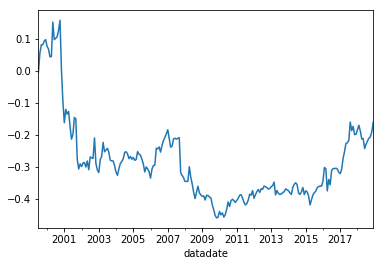

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.097677
2000-12-31   -0.176087
2001-12-31   -0.216595
2002-12-31   -0.027104
2003-12-31    0.019423
2004-12-31    0.029232
2005-12-31   -0.053993
2006-12-31    0.173538
2007-12-31   -0.171648
2008-12-31   -0.080589
2009-12-31   -0.113691
2010-12-31    0.084929
2011-12-31    0.063250
2012-12-31    0.009995
2013-12-31   -0.006364
2014-12-31   -0.023701
2015-12-31    0.042935
2016-12-31    0.068370
2017-12-31    0.174105
2018-12-31    0.048315
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     3.550
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00784
Time:                        21:49:05   Log-Likelihood:                 471.54
No. Observations:                 234   AIC:                            -933.1
Df Residuals:                     229   BIC:                            -915.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.002      0.160      0.873      -0.004       0.005
mktrf          0.0275      0.061      0.452      0.652      -0.092       0.147
me            -0.1939      0.071     -2.741      0.007      -0.333      -0.055
ia            -0.1524      0.108     -1.418      0.158      -0.364       0.059
roe            0.1154      0.092      1.254      0.211      -0.066       0.297
==============================================================================
Omnibus:                       49.331   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              173.020
Skew:                          -0.823   Prob(JB):                     2.69e-38
Kurtosis:                       6.878   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     3.179
Date:                Mon, 27 Apr 2020   Prob (F-statistic):             0.0144
Time:                        21:49:05   Log-Likelihood:                 471.54
No. Observations:                 234   AIC:                            -933.1
Df Residuals:                     229   BIC:                            -915.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.002      0.175      0.861      -0.004       0.004
mktrf          0.0275      0.071      0.387      0.699      -0.112       0.166
me            -0.1939      0.090     -2.159      0.031      -0.370      -0.018
ia            -0.1524      0.135     -1.131      0.258      -0.417       0.112
roe            0.1154      0.144      0.800      0.424      -0.167       0.398
==============================================================================
Omnibus:                       49.331   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              173.020
Skew:                          -0.823   Prob(JB):                     2.69e-38
Kurtosis:                       6.878   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     3.498
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00854
Time:                        21:49:05   Log-Likelihood:                 471.54
No. Observations:                 234   AIC:                            -933.1
Df Residuals:                     229   BIC:                            -915.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.002      0.180      0.857      -0.004       0.004
mktrf          0.0275      0.077      0.358      0.721      -0.123       0.178
me            -0.1939      0.076     -2.548      0.011      -0.343      -0.045
ia            -0.1524      0.136     -1.118      0.263      -0.420       0.115
roe            0.1154      0.151      0.764      0.445      -0.181       0.412
==============================================================================
Omnibus:                       49.331   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              173.020
Skew:                          -0.823   Prob(JB):                     2.69e-38
Kurtosis:                       6.878   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     3.157
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00891
Time:                        21:49:05   Log-Likelihood:                 472.33
No. Observations:                 234   AIC:                            -932.7
Df Residuals:                     228   BIC:                            -911.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.002      0.272      0.786      -0.004       0.005
mktrf          0.0216      0.061      0.355      0.723      -0.098       0.142
smb           -0.2538      0.080     -3.160      0.002      -0.412      -0.096
hml           -0.0749      0.095     -0.791      0.430      -0.262       0.112
rmw            0.0372      0.107      0.348      0.728      -0.174       0.248
cma           -0.0252      0.136     -0.185      0.853      -0.293       0.243
==============================================================================
Omnibus:                       52.814   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              182.896
Skew:                          -0.892   Prob(JB):                     1.93e-40
Kurtosis:                       6.946   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     2.320
Date:                Mon, 27 Apr 2020   Prob (F-statistic):             0.0442
Time:                        21:49:05   Log-Likelihood:                 472.33
No. Observations:                 234   AIC:                            -932.7
Df Residuals:                     228   BIC:                            -911.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.002      0.314      0.754      -0.003       0.004
mktrf          0.0216      0.060      0.363      0.716      -0.095       0.138
smb           -0.2538      0.100     -2.539      0.011      -0.450      -0.058
hml           -0.0749      0.097     -0.771      0.441      -0.266       0.116
rmw            0.0372      0.139      0.269      0.788      -0.234       0.309
cma           -0.0252      0.174     -0.145      0.885      -0.366       0.316
==============================================================================
Omnibus:                       52.814   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              182.896
Skew:                          -0.892   Prob(JB):                     1.93e-40
Kurtosis:                       6.946   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     2.755
Date:                Mon, 27 Apr 2020   Prob (F-statistic):             0.0194
Time:                        21:49:05   Log-Likelihood:                 472.33
No. Observations:                 234   AIC:                            -932.7
Df Residuals:                     228   BIC:                            -911.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.002      0.331      0.741      -0.003       0.004
mktrf          0.0216      0.062      0.347      0.728      -0.100       0.144
smb           -0.2538      0.098     -2.597      0.009      -0.445      -0.062
hml           -0.0749      0.107     -0.700      0.484      -0.285       0.135
rmw            0.0372      0.149      0.250      0.803      -0.255       0.329
cma           -0.0252      0.182     -0.139      0.889      -0.381       0.331
==============================================================================
Omnibus:                       52.814   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              182.896
Skew:                          -0.892   Prob(JB):                     1.93e-40
Kurtosis:                       6.946   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     4.449
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00176
Time:                        21:49:05   Log-Likelihood:                 473.26
No. Observations:                 234   AIC:                            -936.5
Df Residuals:                     229   BIC:                            -919.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.002      0.177      0.860      -0.004       0.005
mktrf          0.0435      0.056      0.783      0.435      -0.066       0.153
smb           -0.2817      0.069     -4.060      0.000      -0.418      -0.145
hml           -0.1137      0.069     -1.649      0.101      -0.249       0.022
umd            0.0554      0.045      1.224      0.222      -0.034       0.144
==============================================================================
Omnibus:                       49.246   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              171.169
Skew:                          -0.824   Prob(JB):                     6.78e-38
Kurtosis:                       6.852   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     3.067
Date:                Mon, 27 Apr 2020   Prob (F-statistic):             0.0173
Time:                        21:49:06   Log-Likelihood:                 473.26
No. Observations:                 234   AIC:                            -936.5
Df Residuals:                     229   BIC:                            -919.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.002      0.194      0.846      -0.003       0.004
mktrf          0.0435      0.051      0.849      0.396      -0.057       0.144
smb           -0.2817      0.095     -2.968      0.003      -0.468      -0.096
hml           -0.1137      0.095     -1.191      0.234      -0.301       0.073
umd            0.0554      0.058      0.957      0.338      -0.058       0.169
==============================================================================
Omnibus:                       49.246   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              171.169
Skew:                          -0.824   Prob(JB):                     6.78e-38
Kurtosis:                       6.852   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     3.870
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00461
Time:                        21:49:06   Log-Likelihood:                 473.26
No. Observations:                 234   AIC:                            -936.5
Df Residuals:                     229   BIC:                            -919.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.002      0.193      0.847      -0.004       0.004
mktrf          0.0435      0.049      0.886      0.376      -0.053       0.140
smb           -0.2817      0.096     -2.944      0.003      -0.469      -0.094
hml           -0.1137      0.081     -1.395      0.163      -0.273       0.046
umd            0.0554      0.059      0.944      0.345      -0.060       0.170
==============================================================================
Omnibus:                       49.246   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              171.169
Skew:                          -0.824   Prob(JB):                     6.78e-38
Kurtosis:                       6.852   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     2.445
Date:                Mon, 27 Apr 2020   Prob (F-statistic):             0.0505
Time:                        21:49:06   Log-Likelihood:                 224.01
No. Observations:                 120   AIC:                            -438.0
Df Residuals:                     115   BIC:                            -424.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0010      0.004     -0.272      0.786      -0.008       0.006
mktrf         -0.0705      0.099     -0.715      0.476      -0.266       0.125
me            -0.2844      0.097     -2.923      0.004      -0.477      -0.092
ia            -0.0439      0.152     -0.288      0.774      -0.346       0.258
roe           -0.0766      0.135     -0.568      0.571      -0.344       0.191
==============================================================================
Omnibus:                       28.313   Durbin-Watson:                   1.884
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.846
Skew:                          -0.945   Prob(JB):                     6.13e-14
Kurtosis:                       5.933   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     2.887
Date:                Mon, 27 Apr 2020   Prob (F-statistic):             0.0255
Time:                        21:49:06   Log-Likelihood:                 224.01
No. Observations:                 120   AIC:                            -438.0
Df Residuals:                     115   BIC:                            -424.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0010      0.003     -0.299      0.765      -0.008       0.006
mktrf         -0.0705      0.102     -0.689      0.491      -0.271       0.130
me            -0.2844      0.110     -2.595      0.009      -0.499      -0.070
ia            -0.0439      0.175     -0.250      0.802      -0.387       0.300
roe           -0.0766      0.174     -0.441      0.659      -0.417       0.264
==============================================================================
Omnibus:                       28.313   Durbin-Watson:                   1.884
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.846
Skew:                          -0.945   Prob(JB):                     6.13e-14
Kurtosis:                       5.933   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     5.354
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000545
Time:                        21:49:06   Log-Likelihood:                 224.01
No. Observations:                 120   AIC:                            -438.0
Df Residuals:                     115   BIC:                            -424.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0010      0.003     -0.300      0.764      -0.007       0.006
mktrf         -0.0705      0.110     -0.640      0.522      -0.286       0.145
me            -0.2844      0.074     -3.847      0.000      -0.429      -0.139
ia            -0.0439      0.164     -0.268      0.789      -0.365       0.277
roe           -0.0766      0.180     -0.425      0.671      -0.429       0.276
==============================================================================
Omnibus:                       28.313   Durbin-Watson:                   1.884
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.846
Skew:                          -0.945   Prob(JB):                     6.13e-14
Kurtosis:                       5.933   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     2.385
Date:                Mon, 27 Apr 2020   Prob (F-statistic):             0.0425
Time:                        21:49:06   Log-Likelihood:                 225.08
No. Observations:                 120   AIC:                            -438.2
Df Residuals:                     114   BIC:                            -421.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.004     -0.081      0.936      -0.008       0.007
mktrf         -0.0896      0.103     -0.867      0.388      -0.294       0.115
smb           -0.3747      0.117     -3.200      0.002      -0.607      -0.143
hml            0.0831      0.144      0.579      0.564      -0.201       0.367
rmw           -0.1897      0.169     -1.121      0.265      -0.525       0.146
cma           -0.0478      0.185     -0.258      0.797      -0.415       0.319
==============================================================================
Omnibus:                       23.625   Durbin-Watson:                   1.858
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.086
Skew:                          -0.803   Prob(JB):                     3.62e-11
Kurtosis:                       5.652   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     3.363
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00717
Time:                        21:49:06   Log-Likelihood:                 225.08
No. Observations:                 120   AIC:                            -438.2
Df Residuals:                     114   BIC:                            -421.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.003     -0.098      0.922      -0.006       0.006
mktrf         -0.0896      0.086     -1.046      0.296      -0.258       0.078
smb           -0.3747      0.122     -3.064      0.002      -0.614      -0.135
hml            0.0831      0.116      0.717      0.473      -0.144       0.310
rmw           -0.1897      0.171     -1.107      0.268      -0.526       0.146
cma           -0.0478      0.202     -0.236      0.813      -0.444       0.349
==============================================================================
Omnibus:                       23.625   Durbin-Watson:                   1.858
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.086
Skew:                          -0.803   Prob(JB):                     3.62e-11
Kurtosis:                       5.652   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     6.522
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.27e-05
Time:                        21:49:06   Log-Likelihood:                 225.08
No. Observations:                 120   AIC:                            -438.2
Df Residuals:                     114   BIC:                            -421.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.003     -0.105      0.917      -0.006       0.005
mktrf         -0.0896      0.091     -0.983      0.326      -0.268       0.089
smb           -0.3747      0.096     -3.905      0.000      -0.563      -0.187
hml            0.0831      0.119      0.700      0.484      -0.150       0.316
rmw           -0.1897      0.178     -1.068      0.286      -0.538       0.159
cma           -0.0478      0.201     -0.238      0.812      -0.441       0.346
==============================================================================
Omnibus:                       23.625   Durbin-Watson:                   1.858
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.086
Skew:                          -0.803   Prob(JB):                     3.62e-11
Kurtosis:                       5.652   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     2.683
Date:                Mon, 27 Apr 2020   Prob (F-statistic):             0.0349
Time:                        21:49:06   Log-Likelihood:                 224.47
No. Observations:                 120   AIC:                            -438.9
Df Residuals:                     115   BIC:                            -425.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.004     -0.486      0.628      -0.009       0.005
mktrf          0.0100      0.086      0.115      0.908      -0.161       0.181
smb           -0.3081      0.098     -3.130      0.002      -0.503      -0.113
hml           -0.0791      0.099     -0.803      0.424      -0.274       0.116
umd            0.0391      0.061      0.643      0.522      -0.081       0.159
==============================================================================
Omnibus:                       27.205   Durbin-Watson:                   1.847
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               61.747
Skew:                          -0.882   Prob(JB):                     3.91e-14
Kurtosis:                       6.040   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     2.759
Date:                Mon, 27 Apr 2020   Prob (F-statistic):             0.0311
Time:                        21:49:06   Log-Likelihood:                 224.47
No. Observations:                 120   AIC:                            -438.9
Df Residuals:                     115   BIC:                            -425.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.003     -0.544      0.586      -0.008       0.005
mktrf          0.0100      0.068      0.146      0.884      -0.124       0.144
smb           -0.3081      0.139     -2.211      0.027      -0.581      -0.035
hml           -0.0791      0.135     -0.585      0.558      -0.344       0.186
umd            0.0391      0.065      0.597      0.550      -0.089       0.167
==============================================================================
Omnibus:                       27.205   Durbin-Watson:                   1.847
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               61.747
Skew:                          -0.882   Prob(JB):                     3.91e-14
Kurtosis:                       6.040   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     3.924
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00505
Time:                        21:49:06   Log-Likelihood:                 224.47
No. Observations:                 120   AIC:                            -438.9
Df Residuals:                     115   BIC:                            -425.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.003     -0.544      0.586      -0.008       0.005
mktrf          0.0100      0.063      0.159      0.873      -0.113       0.133
smb           -0.3081      0.130     -2.372      0.018      -0.563      -0.053
hml           -0.0791      0.116     -0.680      0.497      -0.307       0.149
umd            0.0391      0.068      0.577      0.564      -0.094       0.172
==============================================================================
Omnibus:                       27.205   Durbin-Watson:                   1.847
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               61.747
Skew:                          -0.882   Prob(JB):                     3.91e-14
Kurtosis:                       6.040   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     4.722
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00149
Time:                        21:49:06   Log-Likelihood:                 265.92
No. Observations:                 114   AIC:                            -521.8
Df Residuals:                     109   BIC:                            -508.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.002      0.783      0.435      -0.003       0.007
mktrf          0.0533      0.071      0.755      0.452      -0.087       0.193
me             0.0794      0.109      0.729      0.468      -0.137       0.295
ia            -0.3502      0.151     -2.316      0.022      -0.650      -0.051
roe            0.4647      0.133      3.498      0.001       0.201       0.728
==============================================================================
Omnibus:                        2.329   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.312   Jarque-Bera (JB):                1.871
Skew:                          -0.158   Prob(JB):                        0.392
Kurtosis:                       3.543   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     2.395
Date:                Mon, 27 Apr 2020   Prob (F-statistic):             0.0548
Time:                        21:49:06   Log-Likelihood:                 265.92
No. Observations:                 114   AIC:                            -521.8
Df Residuals:                     109   BIC:                            -508.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.002      1.009      0.313      -0.002       0.006
mktrf          0.0533      0.057      0.928      0.353      -0.059       0.166
me             0.0794      0.125      0.635      0.526      -0.166       0.325
ia            -0.3502      0.184     -1.898      0.058      -0.712       0.011
roe            0.4647      0.190      2.439      0.015       0.091       0.838
==============================================================================
Omnibus:                        2.329   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.312   Jarque-Bera (JB):                1.871
Skew:                          -0.158   Prob(JB):                        0.392
Kurtosis:                       3.543   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     2.566
Date:                Mon, 27 Apr 2020   Prob (F-statistic):             0.0422
Time:                        21:49:06   Log-Likelihood:                 265.92
No. Observations:                 114   AIC:                            -521.8
Df Residuals:                     109   BIC:                            -508.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.002      1.239      0.215      -0.001       0.005
mktrf          0.0533      0.045      1.197      0.231      -0.034       0.141
me             0.0794      0.135      0.586      0.558      -0.186       0.345
ia            -0.3502      0.209     -1.678      0.093      -0.759       0.059
roe            0.4647      0.193      2.413      0.016       0.087       0.842
==============================================================================
Omnibus:                        2.329   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.312   Jarque-Bera (JB):                1.871
Skew:                          -0.158   Prob(JB):                        0.392
Kurtosis:                       3.543   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     2.203
Date:                Mon, 27 Apr 2020   Prob (F-statistic):             0.0592
Time:                        21:49:06   Log-Likelihood:                 262.35
No. Observations:                 114   AIC:                            -512.7
Df Residuals:                     108   BIC:                            -496.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.002      0.942      0.348      -0.003       0.007
mktrf          0.0551      0.070      0.790      0.431      -0.083       0.193
smb           -0.0358      0.113     -0.316      0.752      -0.260       0.189
hml           -0.2571      0.145     -1.779      0.078      -0.544       0.029
rmw            0.1604      0.177      0.907      0.367      -0.190       0.511
cma           -0.0836      0.225     -0.372      0.710      -0.529       0.362
==============================================================================
Omnibus:                        9.008   Durbin-Watson:                   2.110
Prob(Omnibus):                  0.011   Jarque-Bera (JB):               11.881
Skew:                          -0.414   Prob(JB):                      0.00263
Kurtosis:                       4.347   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     3.025
Date:                Mon, 27 Apr 2020   Prob (F-statistic):             0.0135
Time:                        21:49:06   Log-Likelihood:                 262.35
No. Observations:                 114   AIC:                            -512.7
Df Residuals:                     108   BIC:                            -496.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.002      1.119      0.263      -0.002       0.006
mktrf          0.0551      0.059      0.938      0.348      -0.060       0.170
smb           -0.0358      0.115     -0.311      0.756      -0.262       0.190
hml           -0.2571      0.134     -1.917      0.055      -0.520       0.006
rmw            0.1604      0.287      0.559      0.576      -0.402       0.723
cma           -0.0836      0.288     -0.290      0.772      -0.648       0.481
==============================================================================
Omnibus:                        9.008   Durbin-Watson:                   2.110
Prob(Omnibus):                  0.011   Jarque-Bera (JB):               11.881
Skew:                          -0.414   Prob(JB):                      0.00263
Kurtosis:                       4.347   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     4.223
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00152
Time:                        21:49:06   Log-Likelihood:                 262.35
No. Observations:                 114   AIC:                            -512.7
Df Residuals:                     108   BIC:                            -496.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.002      1.288      0.198      -0.001       0.006
mktrf          0.0551      0.053      1.044      0.297      -0.048       0.159
smb           -0.0358      0.133     -0.269      0.788      -0.296       0.225
hml           -0.2571      0.141     -1.820      0.069      -0.534       0.020
rmw            0.1604      0.321      0.499      0.618      -0.470       0.790
cma           -0.0836      0.336     -0.249      0.803      -0.742       0.575
==============================================================================
Omnibus:                        9.008   Durbin-Watson:                   2.110
Prob(Omnibus):                  0.011   Jarque-Bera (JB):               11.881
Skew:                          -0.414   Prob(JB):                      0.00263
Kurtosis:                       4.347   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     2.822
Date:                Mon, 27 Apr 2020   Prob (F-statistic):             0.0284
Time:                        21:49:06   Log-Likelihood:                 262.43
No. Observations:                 114   AIC:                            -514.9
Df Residuals:                     109   BIC:                            -501.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.002      0.902      0.369      -0.003       0.007
mktrf          0.0570      0.069      0.827      0.410      -0.080       0.194
smb           -0.0748      0.108     -0.696      0.488      -0.288       0.138
hml           -0.2738      0.111     -2.472      0.015      -0.493      -0.054
umd            0.0838      0.084      1.002      0.318      -0.082       0.249
==============================================================================
Omnibus:                        8.052   Durbin-Watson:                   2.149
Prob(Omnibus):                  0.018   Jarque-Bera (JB):               13.369
Skew:                          -0.239   Prob(JB):                      0.00125
Kurtosis:                       4.608   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     3.761
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00662
Time:                        21:49:06   Log-Likelihood:                 262.43
No. Observations:                 114   AIC:                            -514.9
Df Residuals:                     109   BIC:                            -501.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.002      0.973      0.330      -0.002       0.007
mktrf          0.0570      0.058      0.977      0.328      -0.057       0.171
smb           -0.0748      0.102     -0.735      0.463      -0.275       0.125
hml           -0.2738      0.101     -2.702      0.007      -0.472      -0.075
umd            0.0838      0.086      0.973      0.331      -0.085       0.253
==============================================================================
Omnibus:                        8.052   Durbin-Watson:                   2.149
Prob(Omnibus):                  0.018   Jarque-Bera (JB):               13.369
Skew:                          -0.239   Prob(JB):                      0.00125
Kurtosis:                       4.608   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     5.083
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000856
Time:                        21:49:06   Log-Likelihood:                 262.43
No. Observations:                 114   AIC:                            -514.9
Df Residuals:                     109   BIC:                            -501.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.002      1.133      0.257      -0.002       0.006
mktrf          0.0570      0.056      1.012      0.312      -0.053       0.167
smb           -0.0748      0.106     -0.707      0.480      -0.282       0.133
hml           -0.2738      0.094     -2.913      0.004      -0.458      -0.090
umd            0.0838      0.074      1.137      0.255      -0.061       0.228
==============================================================================
Omnibus:                        8.052   Durbin-Watson:                   2.149
Prob(Omnibus):                  0.018   Jarque-Bera (JB):               13.369
Skew:                          -0.239   Prob(JB):                      0.00125
Kurtosis:                       4.608   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""